# Bridges
## Framework to Framework language translation

This notebook is a demonstration of translating the `Flutter` framework to the `React Native` framework using the Encoder/Decoder architecture with the attention mechanism. We will train the model on `Flutter` and `React Native` code snippets to learn the mapping between the two frameworks. We will explore different methods for modeling the problem and evaluate the performance of the model.

In [76]:
SAMPLE_SIZE = 1000

## Vectorization of Flutter Packages

### Scraping [pub.dev](https://pub.dev) for Flutter packages

In [77]:
from nltk.tokenize import word_tokenize
import nltk
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

# Download NLTK resources
nltk.download('punkt')

def scrape_url(url) -> dict:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # find all package links with the class 'packages-title'
    packages = soup.find_all('h3', class_='packages-title')
    package_links = [package.find('a') for package in packages]
    descriptions = {}
    for link in package_links:
        package_url = 'https://pub.dev' + link['href']
        package_response = requests.get(package_url)
        package_soup = BeautifulSoup(package_response.text, 'html.parser')
        all_text = package_soup.get_text()
        # remove unknown words from the text based on nltk
        tokens = word_tokenize(all_text)
        words = [word for word in tokens if word.isalpha()]
        all_text = ' '.join(words)
        descriptions[link['href'][10:]] = all_text
    return descriptions

# Function to scrape package descriptions from pub.dev
def scrape_package_descriptions(sample_size=10):
    descriptions = {}
    for i in tqdm(range(1, sample_size//10)):
        url = f'https://pub.dev/packages?q=sdk%3Aflutter&page={i}'
        descriptions |= scrape_url(url)
    return descriptions

# Scrape package descriptions
flutter_descriptions = scrape_package_descriptions(sample_size=SAMPLE_SIZE)
print(f"Scraped {len(flutter_descriptions)} package descriptions")

[nltk_data] Downloading package punkt to /Users/I589104/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 99/99 [02:45<00:00,  1.68s/it]

Scraped 990 package descriptions


### Vectorizing Flutter packages

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

# Extract descriptions and package names
fl_descriptions = list(flutter_descriptions.values())
fl_package_names = list(flutter_descriptions.keys())

# Tokenize and vectorize descriptions
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(fl_descriptions)

# Convert descriptions to vectors
fl_description_vectors = tfidf_matrix.toarray()

# Create a dictionary to store package vectors
fl_package_vectors = {}

# Populate package vectors dictionary
for i, package_name in enumerate(fl_package_names):
    fl_package_vectors[package_name] = fl_description_vectors[i]

# Function to get similarity between two packages
def get_similarity(package1, package2):
    v1 = fl_package_vectors[package1]
    v2 = fl_package_vectors[package2]
    similarity = cosine_similarity([v1], [v2])[0][0]
    return similarity

# Example usage:
package1 = f"{fl_package_names[np.random.randint(len(fl_package_names))]}"
package2 = f"{fl_package_names[np.random.randint(len(fl_package_names))]}"
similarity = get_similarity(package1, package2)
print(f"Similarity between {package1} and {package2}: {similarity}")

Similarity between bloc_concurrency and flutter_chat_ui: 0.012741776790643375


### Graph Embeddings for Flutter Packages

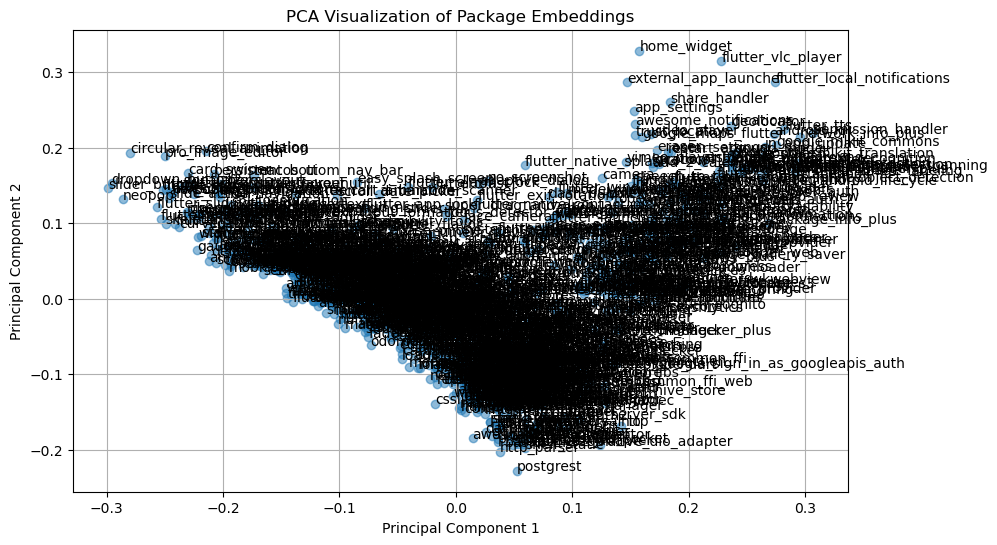

In [79]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(fl_description_vectors)

# Plot embeddings
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
for i, package_name in enumerate(fl_package_names):
    plt.annotate(package_name, (pca_result[i, 0], pca_result[i, 1]))
plt.title('PCA Visualization of Package Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## Vectorization of React Packages

### Scraping [npmjs.com](https://www.npmjs.com) for React packages

In [83]:
from nltk.tokenize import word_tokenize
import nltk
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

# Download NLTK resources
nltk.download('punkt')

def scrape_url(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    # find all package links with the class 'packages-title'
    packages = soup.find_all('div', class_='bea55649 flex flex-row flex-wrap items-end pr3')
    package_links = [package.find('a') for package in packages]
    descriptions = {}
    for link in package_links:
        package_url = 'https://npmjs.com' + link['href']
        package_response = requests.get(package_url)
        package_soup = BeautifulSoup(package_response.text, 'html.parser')
        all_text = package_soup.get_text()
        # remove unknown words from the text based on nltk
        tokens = word_tokenize(all_text)
        words = [word for word in tokens if word.isalpha()]
        all_text = ' '.join(words)
        descriptions[link['href'][10:]] = all_text
    return descriptions

# Function to scrape package descriptions from npmjs.com
def scrape_package_descriptions(sample_size=10):
    descriptions = {}
    for i in tqdm(range(0, sample_size//36)):
        url = f'https://www.npmjs.com/browse/depended/react?offset={36*i}'
        descriptions |= scrape_url(url)
    return descriptions

# Scrape package descriptions
flutter_descriptions = scrape_package_descriptions(sample_size=SAMPLE_SIZE)
print(f"Scraped {len(flutter_descriptions)} package descriptions")

100%|██████████| 27/27 [01:30<00:00,  3.37s/it]

Scraped 394 package descriptions


### Vectorizing React packages

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np

# Extract descriptions and package names
rct_descriptions = list(flutter_descriptions.values())
rct_package_names = list(flutter_descriptions.keys())

# Tokenize and vectorize descriptions
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(rct_descriptions)

# Convert descriptions to vectors
rct_description_vectors = tfidf_matrix.toarray()

# Create a dictionary to store package vectors
rct_package_vectors = {}

# Populate package vectors dictionary
for i, package_name in enumerate(rct_package_names):
    rct_package_vectors[package_name] = rct_description_vectors[i]

# Function to get similarity between two packages
def get_similarity(package1, package2):
    v1 = rct_package_vectors[package1]
    v2 = rct_package_vectors[package2]
    similarity = cosine_similarity([v1], [v2])[0][0]
    return similarity

# Example usage:
package1 = f"{rct_package_names[np.random.randint(len(rct_package_names))]}"
package2 = f"{rct_package_names[np.random.randint(len(rct_package_names))]}"
similarity = get_similarity(package1, package2)
print(f"Similarity between {package1} and {package2}: {similarity}")

Similarity between evolab/notebook and ondamalamjumat81: 0.9999999999999998


### Graph Embeddings for React Packages

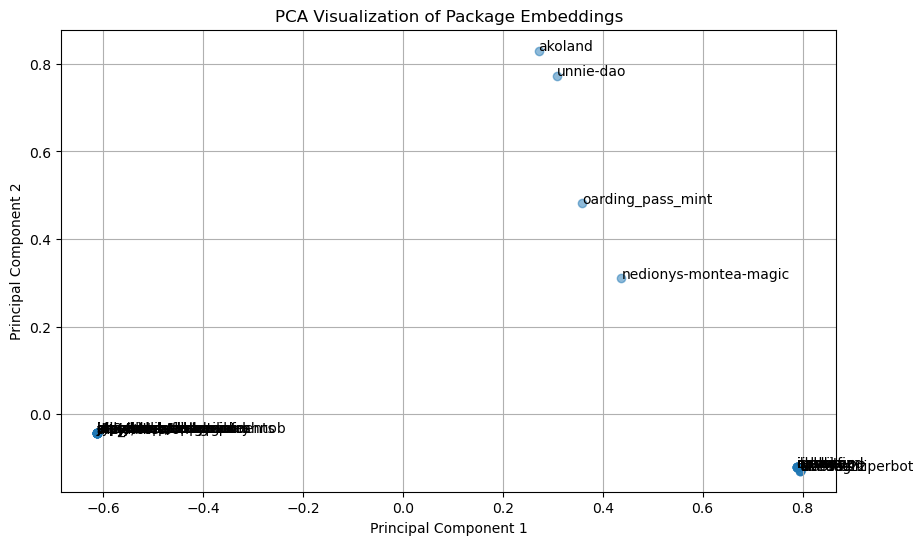

In [82]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rct_description_vectors)

# Plot embeddings
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
for i, package_name in enumerate(rct_package_names):
    plt.annotate(package_name, (pca_result[i, 0], pca_result[i, 1]))
plt.title('PCA Visualization of Package Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## Mapping between Flutter and React Native